# Imports

In [1]:
# calculate parameters imports
import pyomo.environ as pyo
import math
import pandas as pd

# main code imports
import pyomo.environ as pyo

from idaes.core.util.model_statistics import (
    number_variables,
    number_total_equalities,
    number_total_inequalities,
    number_total_constraints,
    number_unfixed_variables,
    number_activated_constraints,
    degrees_of_freedom,
    report_statistics
)

### Create piecewise-linear constraints for CAPEX vs maxFlow
from CapexParams import CAPEXParams

# for catching errors
import sys

# for plotting
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Calculate Parameters

In [2]:
def define_params(
    ###################################################################
    # Sensitivity analysis costing params
    CAPEX_param=1,
    OC_param=1,
    ###################################################################
    recycleRate=0.6,  # collection rate
    preRecycleRate=0.1,  # pre-production recycle rate
    shred_sensitivity=1,  # shredder sensitivity
    HD_sens=1,  # Hydrogen Decrepitation yield sensitivity analysis
    AFDE_sens=0.98,  # Acid-free dissolution extraction yield sensitivity analysis
    auto_eff=0.15,  # how much more efficient automatic dissasembly is than manual disassembly
    priceSensitivity=1,  # price of REO product sensitivity parameter
    gas_HD_eff=0.5,  # efficiency of the gas-fired hydrogen decrepitation unit
):

    # year we start considering pre-plant e-waste
    feed_start = 2014

    # number of EOL Desktops with HDDs
    EOLDesktops = {
        2014: 9284810,
        2015: 9674243,
        2016: 9231439,
        2017: 9937580,
        2018: 8797433,
        2019: 9170444,
        2020: 8800952,
        2021: 7854919,
        2022: 7298247,
        2023: 5809325,
        2024: 4787568,
        2025: 3880104,
        2026: 3712231,
        2027: 3285000,
        2028: 3087313,
        2029: 2788261,
        2030: 2332477,
        2031: 2205356,
        2032: 1963099,
        2033: 1747667,
        2034: 1548760,
        2035: 1359222,
        2036: 1181324,
        2037: 1015165,
        2038: 858384,
    }

    # number of EOL laptops with HDDs
    EOLLaptops = {
        2014: 11350212,
        2015: 15082173,
        2016: 18715924,
        2017: 19487570,
        2018: 28186126,
        2019: 29322550,
        2020: 28200156,
        2021: 24280603,
        2022: 21832640,
        2023: 19094122,
        2024: 17012219,
        2025: 15602359,
        2026: 15650083,
        2027: 14608125,
        2028: 14564179,
        2029: 13582609,
        2030: 11522439,
        2031: 11078718,
        2032: 10028016,
        2033: 9122756,
        2034: 8238943,
        2035: 7384090,
        2036: 6553005,
        2037: 5743730,
        2038: 4954920,
    }

    plant_start = 2024
    # year the plant starts production
    prod_start = 2025  # first year is construction
    # lifetime of plant
    plant_lifetime = 15
    plant_end = plant_start + plant_lifetime - 1  # final year plant is in production
    plant_life_range = pyo.RangeSet(plant_start, plant_end)  # lifetime of the plant
    operational_range = pyo.RangeSet(
        prod_start, plant_end
    )  # operational lifetime of the plant

    # number of years it takes to recycle all the available pre-production HDDs
    preProdYears = 14  # 3 years for the base case

    # pre-plant production Desktop and laptop HDDs available for recycling
    EOLAvailDesktops = {feed_start: 0}
    EOLAvailLaptops = {feed_start: 0}
    tot_mass = 0
    tot_HDDs = 0
    for t in pyo.RangeSet(feed_start, plant_end):
        # pre-plant hdds
        if t < prod_start:
            EOLAvailDesktops[t] = EOLDesktops[t] * preRecycleRate
            EOLAvailLaptops[t] = EOLLaptops[t] * preRecycleRate
        else:
            EOLAvailDesktops[t] = EOLDesktops[t] * recycleRate
            EOLAvailLaptops[t] = EOLLaptops[t] * recycleRate

        tot_mass = 0.187 * EOLAvailLaptops[t] + 1.8016 * EOLAvailDesktops[t]
        tot_HDDs += EOLAvailLaptops[t] + EOLAvailDesktops[t]

    avg_mass = tot_mass / tot_HDDs

    print('average mass (lbs): ', avg_mass)

    # total number of entering HDDs
    enteringHDDs = {prod_start: 0}
    # total number of pre-production HDDs available for recycling
    totPreProdHDDs = 0
    # total number of pre-production large HDDs available for recycling
    totPreProdLargeHDDs = 0
    # total number of pre-production small HDDs available for recycling
    totPreProdSmallHDDs = 0
    for t in pyo.RangeSet(feed_start, plant_end):
        if prod_start <= t:
            enteringHDDs[t] = EOLAvailDesktops[t] + EOLAvailLaptops[t]
            # if t == 2025:
            # print('testing hdds entering in 2025')
            # print(enteringHDDs[t])

        # calculate total pre-production HDDs available for recycling
        if t < prod_start:
            totPreProdHDDs += EOLAvailDesktops[t] + EOLAvailLaptops[t]
            totPreProdSmallHDDs += EOLAvailLaptops[t]
            totPreProdLargeHDDs += EOLAvailDesktops[t]

    # add in previously recycled HDDs into entering HDDs
    for t in pyo.RangeSet(prod_start, plant_end):
        if t < (prod_start + preProdYears):
            enteringHDDs[t] += totPreProdHDDs / preProdYears

    # the amount of REPM entering the plant in a given year (kg)
    amountREPM = {feed_start: 0}

    # total amount of pre-production REPM available for recycling
    totPreProdREPM = 0
    REPM_Large_HDD = 0
    REPM_Small_HDD = 0.0025  # kg

    # total hdds entering the plant each year
    total_HDDs = {feed_start: 0}
    totalPreProdHDDs = 0
    # print('Large REPM')
    for t in pyo.RangeSet(feed_start, plant_end):
        # REPM for large HDDs is decreasing linearly (Sprecher et al.) Will assume this correlation holds
        # until large HDDs reach the same amount as small HDDs. After which the amount will stay constant.
        REPM_Large_HDD = (17.87 - 0.35 * (t - 1990)) / 1000

        # print(REPM_Large_HDD)
        if REPM_Large_HDD < REPM_Small_HDD:
            REPM_Large_HDD = REPM_Small_HDD

        amountREPM[t] = (
            EOLAvailDesktops[t] * REPM_Large_HDD + EOLAvailLaptops[t] * REPM_Small_HDD
        )

        total_HDDs[t] = EOLAvailDesktops[t] + EOLAvailLaptops[t]

        # calculate total pre-production REPM available for recycling
        if t < prod_start:
            totPreProdREPM += amountREPM[t]
            totalPreProdHDDs += total_HDDs[t]

    # add in previously recycled REPM into feed flow
    for t in pyo.RangeSet(prod_start, plant_end):
        if t < (prod_start + preProdYears):
            # print(t)
            # print('pre-production REPM')
            # print(str(totPreProdREPM / preProdYears))
            amountREPM[t] += totPreProdREPM / preProdYears
            total_HDDs[t] += totalPreProdHDDs / preProdYears

    prod_REPM_flows = {prod_start: 0}
    for t in pyo.RangeSet(prod_start, plant_end):
        prod_REPM_flows[t] = amountREPM[t]
        # tot_recycled_REPM += amountREPM[t]

    # average composition per hdd each year
    avg_REPM_per_HDD = sum(
        amountREPM[t] for t in pyo.RangeSet(feed_start, plant_end)
    ) / sum(total_HDDs[t] for t in pyo.RangeSet(feed_start, plant_end))

    # avg_REPM_per_HDD = {feed_start: 0}

    # for t in pyo.RangeSet(prod_start, plant_end):
    #     if (EOLAvailDesktops[t] + EOLAvailLaptops[t]) == 0:
    #         avg_REPM_per_HDD[t] = 0

    #     avg_REPM_per_HDD[t] = amountREPM[t] / total_HDDs[t]

    max_REPM_flow = max(prod_REPM_flows.values())
    max_REPM_flow_year = max(prod_REPM_flows, key=amountREPM.get)

    # define key components
    Key_comps = ["Nd", "Fe"]

    ### mass flow balances
    # dictionary of wt. % components
    HDD_Composition = {"Nd": 0.3, "Fe": 0.70}

    # sensitivity value for shredding efficiency
    # dictionary of node and yield for each component. NEED TO UPDATE THIS
    Option_Eff = {
        # Level 1 yields
        (1, 1): {"Nd": 1, "Fe": 1},
        (1, 2): {"Nd": 1, "Fe": 1},
        (1, 3): {"Nd": 1, "Fe": 1},
        (1, 4): {"Nd": shred_sensitivity, "Fe": shred_sensitivity},
        # level 2 yields
        (2, 1): {"Nd": 1, "Fe": 1},
        (2, 2): {"Nd": 1, "Fe": 1},
        (2, 3): {"Nd": 1, "Fe": 1},
        (2, 4): {"Nd": 1, "Fe": 1},
        # level 3 yields
        (3, 1): {"Nd": 0.985, "Fe": 0},
        (3, 2): {"Nd": 0.925, "Fe": 0},
        (3, 3): {"Nd": 1, "Fe": 0},
        (3, 4): {"Nd": 1, "Fe": 1},
        # level 4 yields
        (4, 1): {"Nd": 1, "Fe": 0},
        (4, 2): {"Nd": 0.98, "Fe": 0},
        (4, 3): {"Nd": AFDE_sens, "Fe": 0},
    }

    ### Costing
    ## Disassembly Costing

    # rate of manual disassembly for small HDDs (HDDs/yr)
    rate_man_small = 181132
    # rate of manual disassembly for large HDDs (HDDs/yr)
    # rate_man_large = 127433
    rate_man_large = 181132

    # rate of automatic disassembly for small HDDs (HDDs/yr)
    # rate_auto_small = 514285
    rate_auto_small = 523636
    # rate of automatic disassembly for large HDDs (HDDs/yr)
    rate_auto_large = 523636

    # dictionaries for manual rate or automatic rate of disassembly in a given year
    Man_Rate_Dis = {plant_start: 0}
    Auto_Rate_Dis = {plant_start: 0}

    for t in pyo.RangeSet(prod_start, plant_end):
        incomingSmallHDDs = 0
        incomingLargeHDDs = 0
        # no disassembly first year of plant life
        if t == plant_start:
            Man_Rate_Dis[t] = 0
            Auto_Rate_Dis[t] = 0

        else:

            incomingSmallHDDs = EOLAvailLaptops[t]
            incomingLargeHDDs = EOLAvailDesktops[t]

            # account for pre-production EOL HDD recycling
            if t < (prod_start + preProdYears):
                incomingSmallHDDs += totPreProdSmallHDDs / preProdYears
                incomingLargeHDDs += totPreProdLargeHDDs / preProdYears

            # calculate proportion of incoming HDDs that are small
            propSmallHDDs = incomingSmallHDDs / (incomingSmallHDDs + incomingLargeHDDs)
            Man_Rate_Dis[t] = (
                propSmallHDDs * rate_man_small + (1 - propSmallHDDs) * rate_man_large
            )

            Auto_Rate_Dis[t] = (
                propSmallHDDs * rate_auto_small + (1 - propSmallHDDs) * rate_auto_large
            )

    # rate of the shredder (HDD size agnostic) (HDDs/yr)
    Shred_Rate = 2.16e7
    # max no. of HDDs entering the plant over its lifetime in a year
    maxHDDs = max(enteringHDDs.values())
    maxHDDsYear = max(zip(enteringHDDs.values(), enteringHDDs.keys()))[1]

    # rate of the sectioning (HDD size agnostic) (HDDs/yr) 2 HDDs per min
    Sect_Rate = 960000

    # thousands of HDDs/yr/unit
    Dis_Rate = {
        (1, 1): 181132/1000,
        (1, 2): 523636/1000,
        (1, 3): 960000/1000,
        (1, 4): 2.16e7/1000,
    }

    ###################### need to update this ######################
    from math import ceil

    print("\n")
    Dis_units_by_year_manual = {prod_start: 0}
    Dis_units_by_year_automatic = {prod_start: 0}
    for t in operational_range:
        # print('manual disassembly rate in year ' + str(t) + ' is ' + str(Man_Rate_Dis[t]))
        # print('automatic disassembly rate in year ' + str(t) + ' is ' + str(Auto_Rate_Dis[t]))
        # print('\n')
        Dis_units_by_year_manual[t] = ceil(enteringHDDs[t] / Man_Rate_Dis[t])
        Dis_units_by_year_automatic[t] = ceil(enteringHDDs[t] / Auto_Rate_Dis[t])

    # calculate the no. of manual units needed
    # Dis_units_manual = max(Dis_units_by_year_manual.values())

    # calculate the no. of automatic units needed
    # Dis_units_automatic = max(Dis_units_by_year_automatic.values())

    Dis_units_manual = ceil(enteringHDDs[maxHDDsYear] / rate_man_large)

    Dis_units_automatic = ceil(enteringHDDs[maxHDDsYear] / rate_auto_large)

    Dis_units_shred = ceil(enteringHDDs[maxHDDsYear] / Shred_Rate)

    Dis_units_sect = ceil(enteringHDDs[maxHDDsYear] / Sect_Rate)

    # list of options with discrete units
    Discrete_Opts = [(1, 1), (1, 2), (1, 3), (1, 4)]

    discr_units = {
        (1, 1): Dis_units_manual,
        (1, 2): Dis_units_automatic,
        (1, 3): Dis_units_sect,
        (1, 4): Dis_units_shred,
    }

    print("no. of units:")
    print(discr_units)

    # Define the cost per robot ($/unit)
    RC = 200000  # 200K per robot
    # R_LT = 5 # service lifetime of 5 years
    # RC = R_cost * (plant_lifetime/R_LT)

    # Define cost per shredder ($/unit)
    SC = 50000

    # installation costs per unit
    CU = {
        (1, 1): 0,  # manual disassembly
        (1, 2): RC / 1000,  # automatic disassembly
        (1, 3): 0,  # manual sectioning
        (1, 4): SC / 1000,  # Shredders
    }

    # define the yearly cost per robot ($/unit*yr)
    YCR = 280

    # define the yearly cost per shredder ($/unit*yr)
    # 20 HP/14.71kW motor
    # 0.07 $/kWh
    YCS = 14.71 * 8000 * 0.0881

    # yearly variable cost per unit (k$/units*yr)
    YCU = {
        (1, 1): 0,  # manual disassembly
        (1, 2): YCR / 1000,  # automatic disassembly
        (1, 3): 0,  # manual sectioning
        (1, 4): (YCS / 1000) * OC_param,  # shredder
    }

    ############################ NEED TO UPDATE THIS ############################
    ############################ Operator Parameters ############################
    # name of workers:
    labor_type = [
        "operators",
    ]

    # yearly labor rates
    labor_rates = {
        "operators": (8000 * 38.20) / 1000,
    }

    # number of operators per option
    num_workers = {
        ##############################################
        # for disassembly stage, its operators per unit
        (1, 1): {
            "operators": 1,
        },
        (1, 2): {
            "operators": 0,
        },
        (1, 3): {
            "operators": 1,
        },
        (1, 4): {
            "operators": 0.3,
        },
        ##############################################
        (2, 1): {
            "operators": 0.65,
        },
        (2, 2): {
            "operators": 0.65,
        },
        (2, 3): {
            "operators": 0.65,
        },
        (2, 4): {
            "operators": 0.65,
        },
        (3, 1): {
            "operators": 1.6,
        },
        (3, 2): {
            "operators": 1.3,
        },
        (3, 3): {
            "operators": 0.45,
        },
        (3, 4): {
            "operators": 1.15,
        },
        (4, 1): {
            "operators": 0,
        },
        (4, 2): {
            "operators": 0.75,
        },
        (4, 3): {
            "operators": 1.15,
        },
    }

    ########################### Calculate the hydrogen decrepitation OC params ############################
    # gas_HD_eff = 0.5
    energy_data = np.array( # before efficiency. units of MMBTU/hr
        [
            0.0167840612727081,
            0.0673810480853261,
            0.113956100414689,
            0.145790125155248,
            0.193321728234016,
            0.311754123239351,
            0.415323570762387,
            0.556415590551056,
        ]
    )

    energy_data_eff = energy_data / gas_HD_eff
    # print(energy_data_eff)

    gas_HD_cost_hourly = energy_data_eff * 2.53
    # print(gas_HD_cost_hourly)

    # scaled to k$ per year
    gas_HD_cost_yearly = (gas_HD_cost_hourly * 8000) / 1000
    print('HD yearly cost:')
    print(gas_HD_cost_yearly)

    # flows scaled to metric tonnes per year
    # reshape x data to be 2d
    yearly_flows = np.array([36480/1000, 634240/1000, 1434800/1000, 2083760/1000, 3171200/1000, 6342400/1000, 9513600/1000, 14270400/1000]).reshape((-1,1))

    gas_HD_model = LinearRegression().fit(yearly_flows, gas_HD_cost_yearly)
    r_sq = gas_HD_model.score(yearly_flows, gas_HD_cost_yearly)
    print('HD unit mode R-squared and params:')
    print(r_sq)
    print(gas_HD_model.intercept_)
    print(gas_HD_model.coef_[0])
    #######################################################################################################

    ############################ NEED TO UPDATE THIS ############################
    ############################ OPEX Parameters ################################
    # for all options excluding the disassembly stage, the OPEX costs are linearly related to the flow entering it.
    # OPEX = a*F_in + b*y
    # everything scaled for metric tonnes (flow) vs. k$
    N_OC_var = {
        # level 2
        (2, 1): {"a": 0.0053, "b": 7929.7/1000},  # done!
        (2, 2): {"a": gas_HD_model.coef_[0]  * OC_param, "b": gas_HD_model.intercept_ * OC_param},
        (2, 3): {"a": 0.0034, "b": 0},  # done!
        (2, 4): {"a": 0.0117, "b": 0},  # done!
        # level 3
        (3, 1): {"a": 15.594, "b": 4e6 / 1000},  # done!
        (3, 2): {"a": 1.8359, "b": 0},  # done!
        # (3, 3): {"a": 3.7414, "b": 2378.6 / 1000},  # done!
        (3, 3): {"a": 3.7414, "b": 3476.7 / 1000},  # done!
        (3, 4): {"a": 1.58 * OC_param, "b": 0 * OC_param},  # done!
        # level 4
        (4, 1): {"a": 0.4997, "b": 89832 / 1000},  # done!
        (4, 2): {"a": 9.8352, "b": 677751 / 1000},  # done!
        (4, 3): {"a": 2.17 * OC_param, "b": 0 * OC_param},  # done!
    }

    Nd2O3_val = 42 * priceSensitivity
    # Nd2O3_val = 229.54 * priceSensitivity


    # Environmental Impacts Matrix
    environ_impacts = {
        (1, 1): 0,
        (1, 2): 600,
        (1, 3): 800,
        (1, 4): 1000,

        (2, 1): 0,
        (2, 2): 1000,
        (2, 3): 800,
        (2, 4): 600,

        (3, 1): 0,
        (3, 2): 800,
        (3, 3): 600,
        (3, 4): 1000,

        (4, 1): 0,
        (4, 2): 800,
        (4, 3): 1000,
    }

    

    print(amountREPM)
    print(totPreProdREPM)
    print("yearly average REPM per HDD:")
    print(avg_REPM_per_HDD)
    print("max flow year: ", max_REPM_flow_year)
    print("entering hdds")
    print(enteringHDDs)

    return (
        avg_mass,
        amountREPM,
        enteringHDDs,
        max_REPM_flow,
        max_REPM_flow_year,
        avg_REPM_per_HDD,
        Nd2O3_val,
        N_OC_var,
        num_workers,
        CU,
        YCU,
        Option_Eff,
        discr_units,
        environ_impacts,
    )

# Main code

In [3]:
def run_model(
    ###################################################################################################
    # Superstructure formulation parameters
    # number of levels
    numStages=4,
    Options_in_stage={1: 4, 2: 4, 3: 4, 4: 3},
    # set of options k' in stage j+1 connected to option k in stage j
    Option_outlets={
        # level 1
        (1, 1): [1, 2, 3, 4],
        (1, 2): [1, 2, 3, 4],
        (1, 3): [1, 2],
        (1, 4): [1, 2, 3, 4],
        # level 2
        (2, 1): [1, 2, 4],
        (2, 2): [1, 2, 4],
        (2, 3): [1, 2, 4],
        (2, 4): [3],
        # level 3
        (3, 1): [1],
        (3, 2): [2],
        (3, 3): [2],
        (3, 4): [3],
    },
    Discrete_Opts=[(1, 1), (1, 2), (1, 3), (1, 4)],
    ###################################################################################################
    ###################################################################################################
    # Plant Lifetime Parameters
    # years of plant operation (starting from 2024 and counting up)
    # year 1 (2024) is plant construction.
    # years 2 through 14 (2025 - 2038) are plant operation
    # plant start date
    plant_start=2024,
    # year the plant starts production
    prod_start=2025,  # first year is construction
    # lifetime of plant
    plant_lifetime=15,
    recycle_all=False, # recycle all possible material each year?
    ###################################################################################################
    ###################################################################################################
    # Feed parameters
    amountREPM=None,  # feed entering plant; dependent on collection rate
    enteringHDDs=None,  # amount of HDDs entering each year
    max_REPM_flow=None,  # max feed entering the plant
    max_REPM_flow_year=None,  # year max feed enters the plant
    Key_comps=["Nd", "Fe"],  # key components
    HDD_Composition={"Nd": 0.3, "Fe": 0.70},  # mass of key component per hev
    avg_REPM_per_HDD=None,  # average REPM per HDD
    avg_mass=None, # average mass (lbs) per HDD
    HDD_price=0, # price per HDD ($/lbs)
    ###################################################################################################
    ###################################################################################################
    # Costing Parameters
    LF=2.97,  # Lang Factor
    ATWACC=0.0577,  # discount rate. ATWACC of 5.77%
    i_OC_esc=0.03,  # opex, revenue (3%)
    i_CAP_esc=0.036,  # capex escalation rate (3.6%)
    f_exp=[0.1, 0.6, 0.3],  # capital expenditure schedule (10%, 60%, 30%)
    CAPEX_param=None,  # capital expense param
    ###################################################################################################
    ###################################################################################################
    # Operating Parameters
    Nd2O3_val=None,  # profit per thousands of kg of Nd2O3.
    N_OC_var=None,  # operating cost parameters
    num_workers=None,  # number of operators per option
    labor_type=["operators"],  # type of labor considered
    labor_rates={"operators": 8000 * 38.20 / 1000},  # rates per type of labor
    YCU=None,  # yearly variable costs per disassembly unit
    CU=None,  # costs per disassembly unit
    Option_Eff=None,  # option efficiency
    discr_units=None,  # no. dis. units per option
    Dis_Rate={ # thousands of HDDs per unit per year
        (1, 1): 181132 / 1000,
        (1, 2): 523636 / 1000,
        (1, 3): 960000 / 1000,
        (1, 4): 2.16e7 / 1000,
    },
    ###################################################################################################
    ###################################################################################################
    # Choice of objective function. Options are 'NPV' or 'COR'.capitalize
    obj_func="NPV",
    # conversion of kg REE/Fe to kg REO/Fe2O3
    kg_Nd2O3_per_kg_Nd=1.1664,
    ###################################################################################################
    ###################################################################################################
    # environmental impacts matrix
    environ_impacts=None,
    epsilon=None,
):

    ###################################################################################################
    maxOptions = max(
        Options_in_stage.values()
    )  # Calculate Superstructure formulation parameters
    final_opt_list = [
        (numStages, j) for j in pyo.RangeSet(Options_in_stage[numStages])
    ]  # make a list of the options in the final stage
    ###################################################################################################

    ###################################################################################################
    # CalculatePlant Lifetime Parameters
    plant_end = plant_start + 15 - 1  # final year plant is in production
    plant_life_range = pyo.RangeSet(plant_start, plant_end)  # lifetime of the plant
    operational_range = pyo.RangeSet(
        prod_start, plant_end
    )  # operational lifetime of the plant
    ###################################################################################################

    m = pyo.ConcreteModel()
    b = pyo.ConcreteModel()

    if obj_func == "COR":
        m.COR = pyo.Var(domain=pyo.NonNegativeReals)

    def cash_flow_block_rule(b, t):

        # These sets will be used to define the flow vars
        b.J = pyo.RangeSet(numStages)  # number of stages
        b.K = pyo.RangeSet(maxOptions)  # max options in a stage
        b.KeyComps = pyo.Set(initialize=Key_comps)  # key components
        jk = []  # for declaring bin vars
        jkc = []  # for declaring flow vars
        for j in b.J:
            for k in pyo.RangeSet(Options_in_stage[j]):
                jk.append((j, k))
                for c in b.KeyComps:
                    jkc.append((j, k, c))


        ### declare stream vars
        # all flows are in metric tonnes (thousands of kgs/yr)

        # amount of EOL products chosen to be recycled
        b.P_entering = pyo.Var(domain=pyo.NonNegativeReals)

        # F is stream entering each stage (except last stage). indexed by j, c, t.
        # Thus,
        b.F_stages = pyo.RangeSet(1, numStages - 1)

        b.F = pyo.Var(b.F_stages * b.KeyComps, domain=pyo.NonNegativeReals)

        # F^in is stream entering each option
        # F^out is stream leaving each option
        b.FlowSet = pyo.Set(within=b.J * b.K * b.KeyComps, initialize=jkc)
        b.F_in = pyo.Var(b.FlowSet, domain=pyo.NonNegativeReals)
        b.F_out = pyo.Var(b.FlowSet, domain=pyo.NonNegativeReals)

        # set of options
        b.OptSet = pyo.Set(within=b.J * b.K, initialize=jk)

        ### Mass Balances
        b.init_flow_cons = pyo.ConstraintList()  # eqn. 2
        b.inlet_flow_cons = pyo.ConstraintList()  # eqn. 1
        b.interm_flow_cons = pyo.ConstraintList()  # eqn. 3
        b.outlet_flow_cons = pyo.ConstraintList()  # eqn. 4

        # P_entering scaled to thousands of HDDs/yr
        b.inlet_flow_cons.add(
            expr=m.plantYear[t].P_entering == enteringHDDs[t] / 1000
        )
        
        for j in b.J:
            num_options = pyo.RangeSet(Options_in_stage[j])

            if j == 1:
                # eqn. 2
                for c in b.KeyComps:
                    b.init_flow_cons.add(
                        expr=( m.plantYear[t].P_entering * avg_REPM_per_HDD * HDD_Composition[c] )
                        == sum(b.F_in[j, k, c] for k in num_options)
                    )

            else:
                # eqn. 1
                for c in b.KeyComps:
                    b.inlet_flow_cons.add(
                        expr=b.F[j - 1, c]
                        == sum(b.F_in[j, k, c] for k in num_options)
                    )

            if j != numStages:
                # eqn. 4
                for c in b.KeyComps:
                    b.outlet_flow_cons.add(
                        expr=sum(b.F_out[j, k, c] for k in num_options) == b.F[j, c]
                    )

        # eqn. 3
        for j in b.J:
            num_options = pyo.RangeSet(Options_in_stage[j])
            for k in num_options:
                for c in b.KeyComps:
                    a = Option_Eff[(j, k)][c]
                    b.interm_flow_cons.add(
                        expr=b.F_in[j, k, c] * a == b.F_out[j, k, c]
                    )
        ### consideration of yearly environmental impacts
        b.total_yearly_GWP = pyo.Var(domain=pyo.NonNegativeReals)
        b.yearly_GWP = pyo.Var(b.OptSet, domain=pyo.NonNegativeReals)
        b.GWP_cons = pyo.ConstraintList()

        # calculate GWP associated with each technology option
        for j in b.J:
            num_options = pyo.RangeSet(Options_in_stage[j])
            for k in num_options:
                b.GWP_cons.add(expr= b.yearly_GWP[j,k] == sum(b.F_in[j,k,c] for c in b.KeyComps) * environ_impacts[j,k])

        # calculate the total GWP for the year
        b.GWP_cons.add(expr= b.total_yearly_GWP == sum(b.yearly_GWP[elem] for elem in b.OptSet))




    # build mass balance constraints for each year the plant is in operation.
    m.plant_year = pyo.RangeSet(prod_start, plant_end)
    m.plantYear = pyo.Block(m.plant_year, rule=cash_flow_block_rule)




    # These sets will be used to define the binary and flow vars
    m.J = pyo.RangeSet(numStages)  # number of stages
    m.K = pyo.RangeSet(maxOptions)  # max options in a stage
    m.KeyComps = pyo.Set(initialize=Key_comps)  # key components
    jk = []  # for declaring bin vars
    jkc = []  # for declaring flow vars
    for j in m.J:
        for k in pyo.RangeSet(Options_in_stage[j]):
            jk.append((j, k))
            for c in m.KeyComps:
                jkc.append((j, k, c))

    ### declare binary variables
    m.OptSet = pyo.Set(within=m.J * m.K, initialize=jk)
    m.binOpt = pyo.Var(m.OptSet, domain=pyo.Binary)

    ### Logical Constraints
    # eqn. 5
    m.stage_bin_cons = pyo.ConstraintList()
    for j in m.J:
        num_options = pyo.RangeSet(Options_in_stage[j])
        m.stage_bin_cons.add(expr=sum(m.binOpt[j, k] for k in num_options) == 1)

    # eqn. 6
    m.connect_bin_cons = pyo.ConstraintList()
    j = 0
    for j in pyo.RangeSet(1, numStages - 1):
        num_options = pyo.RangeSet(Options_in_stage[j])

        k = 0
        for k in num_options:
            opt_connects = Option_outlets[(j, k)]
            m.connect_bin_cons.add(
                expr=1
                - m.binOpt[j, k]
                + sum(m.binOpt[j + 1, kp] for kp in opt_connects)
                >= 1
            )

    # big-M constraints
    m.big_M_cons = pyo.ConstraintList()
    M = max_REPM_flow / 100

    for t in pyo.RangeSet(prod_start, plant_end):
        for j in m.J:
            num_options = pyo.RangeSet(Options_in_stage[j])

            for k in num_options:
                for c in m.KeyComps:
                    m.big_M_cons.add(
                        expr=m.plantYear[t].F_in[j, k, c] <= m.binOpt[j, k] * M
                    )  # eqn. 7
                    m.big_M_cons.add(
                        expr=m.plantYear[t].F_out[j, k, c] <= m.binOpt[j, k] * M
                    )  # eqn. 8

    # define disassembly works set
    m.J_dis = pyo.RangeSet(1)  # number of stages
    m.K_dis = pyo.RangeSet(maxOptions)  # max options in a stage
    max_dis_workers = discr_units[1, 1] + 10
    dis_workers_range = pyo.RangeSet(0, max_dis_workers)
    jk_dis = []
    jkw_dis = []  # for declaring bin vars
    for j_dis in m.J_dis:
        for k_dis in pyo.RangeSet(Options_in_stage[j_dis]):
            jk_dis.append((j_dis, k_dis))
            for w_dis in dis_workers_range:
                jkw_dis.append((j_dis, k_dis, w_dis))

    m.disOpts = pyo.Set(within=m.J_dis * m.K_dis, initialize=jk_dis)
    m.DisOptWorkersSet = pyo.Set(
        within=m.J_dis * m.K_dis * dis_workers_range, initialize=jkw_dis
    )
    m.DisOptWorkers = pyo.Var(m.DisOptWorkersSet, domain=pyo.Binary)

    ################################################ Cash Flow Constraints ################################################
    m.OC_var_cons = pyo.ConstraintList()
    m.DisWorkerCons = pyo.ConstraintList() # for the disassembly stage
     # calculate profit
    m.final_opt_set = pyo.Set(
        initialize=final_opt_list
    )  # list of final node list
    m.profit_opt_cons = pyo.ConstraintList()

    # opex and profit only calculated once production starts
    for t in pyo.RangeSet(prod_start, plant_end):
        m.plantYear[t].OC_var = pyo.Var(m.OptSet, domain=pyo.Reals)

        # must be enough dis units to handle incoming feed each year.
        m.DisWorkerCons.add(
            expr=m.plantYear[t].P_entering
            <= sum(
                Dis_Rate[elem]
                * sum(i * m.DisOptWorkers[elem + (i,)] for i in dis_workers_range)
                for elem in m.disOpts
            )
        )

        for elem in m.disOpts:
            # only 1 'amount' of workers can be chosen.
            m.DisWorkerCons.add(
                expr=sum(m.DisOptWorkers[elem + (i,)] for i in dis_workers_range)
                == 1
            )

            # if a disassembly option is not chosen, then that 'amount' must be 0
            m.DisWorkerCons.add(
                expr=m.binOpt[elem] >= 1 - m.DisOptWorkers[elem + (0,)]
            )

        # calculate variable costs for disassembly stage
        j = 1
        k = 0
        for k in pyo.RangeSet(Options_in_stage[j]):
            option = (j, k)
            m.OC_var_cons.add(
                expr=m.plantYear[t].OC_var[option]
                == sum(
                    m.DisOptWorkers[option + (i,)] * i for i in dis_workers_range
                )
                * YCU[option]
            )

        # calculate variable costs for rest of stages
        for elem in m.OptSet:
            j = 0
            k = 0
            j, k = elem
            if j > 1:  # already calculated opex for discretized options
                m.OC_var_cons.add(
                    expr=m.plantYear[t].OC_var[elem]
                    == N_OC_var[elem]["a"]
                    * sum(m.plantYear[t].F_in[elem + (c,)] for c in m.KeyComps)
                    + N_OC_var[elem]["b"] * m.binOpt[elem]
                )

        # calculate total variable cost
        m.plantYear[t].OC_var_total = pyo.Var(domain=pyo.Reals)
        m.OC_var_cons.add(
            expr=m.plantYear[t].OC_var_total == sum(m.plantYear[t].OC_var[elem] for elem in m.OptSet)
        )

        m.plantYear[t].ProfitOpt = pyo.Var(m.final_opt_set)

        if obj_func == "NPV":
            for opt in m.final_opt_set:
                m.profit_opt_cons.add(
                    expr=m.plantYear[t].ProfitOpt[opt]
                    == m.plantYear[t].F_out[opt + ("Nd",)] * kg_Nd2O3_per_kg_Nd * Nd2O3_val
                )
        elif obj_func == "COR":
            for opt in m.final_opt_set:
                m.profit_opt_cons.add(
                    expr=m.plantYear[t].ProfitOpt[opt]
                    == m.plantYear[t].F_out[opt + ("Nd",)] * kg_Nd2O3_per_kg_Nd * m.COR
                )
        else:
            sys.exit("No objective function chosen.")

        m.plantYear[t].Profit = pyo.Var(domain=pyo.NonNegativeReals)
        m.plantYear[t].profit_con = pyo.Constraint(
            expr=m.plantYear[t].Profit == sum(m.plantYear[t].ProfitOpt[opt] for opt in m.final_opt_set)
        )

    ################################################ OC_fixed Constraints ################################################
    # calculate the cost of labor
    m.COL = pyo.Var(m.OptSet, domain=pyo.Reals)
    m.workers = pyo.Var(m.OptSet, domain=pyo.Reals)
    m.worker_cons = pyo.ConstraintList()
    m.COL_cons = pyo.ConstraintList()

    # calculate the number of workers for each stage
    max_dis_workers = discr_units[1, 1] + 10
    dis_workers_range = pyo.RangeSet(0, max_dis_workers)
    j = 0
    for j in pyo.RangeSet(1, numStages):
        k = 0
        elem = 0
        for k in pyo.RangeSet(Options_in_stage[j]):
            elem = (j, k)
            if j == 1:
                m.worker_cons.add(
                    expr=m.workers[j, k]
                    == sum(
                        i * m.DisOptWorkers[j, k, i]
                        for i in dis_workers_range
                    )
                    * num_workers[elem]["operators"]
                )
            else:
                m.worker_cons.add(
                    expr=m.workers[j, k]
                    == m.binOpt[j, k]
                    * num_workers[elem]["operators"]
                )

    m.workers_range = pyo.RangeSet(0, discr_units[1,1]+10)
    m.bin_workers = pyo.Var(m.workers_range, domain=pyo.Binary)
    m.total_workers = pyo.Var(domain=pyo.Reals)

    m.worker_cons.add(
        expr=sum(m.workers[elem] for elem in m.OptSet)
        <= sum(i * m.bin_workers[i] for i in m.workers_range)
    )
    m.worker_cons.add(expr=sum(m.bin_workers[i] for i in m.workers_range) == 1)

    m.worker_cons.add(
        expr=m.total_workers == sum(i * m.bin_workers[i] for i in m.workers_range)
    )

    # calculate total COL
    # cost in k$
    m.COL_Total = pyo.Var(domain=pyo.NonNegativeReals)
    m.COL_Total_con = pyo.Constraint(
        expr=m.COL_Total == m.total_workers * labor_rates["operators"]
    )

    ################################################ CAPEX Constraints ################################################
    t_max = max_REPM_flow_year

    # TPC = BEC * LF
    m.BEC = pyo.Var(m.OptSet, domain=pyo.NonNegativeReals)
    m.BEC_cons = pyo.ConstraintList()

    # make a var for the max flow entering each option. Used to calculate capex
    maxFlowUB = max_REPM_flow / 100
    m.BEC_max_flow = pyo.Var(m.OptSet, bounds=(0, maxFlowUB))
    m.BEC_max_flow_cons = pyo.ConstraintList()

    # Calculate BEC for discrete units
    k = 0
    for k in pyo.RangeSet(Options_in_stage[1]):
        m.BEC_cons.add(
            expr=m.BEC[1, k]
            == sum(
                i * m.DisOptWorkers[1, k, i] for i in dis_workers_range
            )
            * CU[1, k]
        )

    # calculate BEC for rest of stages
    for elem in m.OptSet:
        j, k = elem
        if j > 1:  # already calculated capex for disassembly stage
            # find the max flow (flow must be >= all flows entering it)
            # scaled to be kg / yr
            for t in pyo.RangeSet(prod_start, plant_end):
                m.BEC_max_flow_cons.add(
                    expr= m.BEC_max_flow[elem] >= sum(
                        m.plantYear[t].F_in[elem + (c,)]
                        for c in m.KeyComps
                    )
                )

    j = 0
    k = 0
    for j in pyo.RangeSet(2, numStages):
        for k in pyo.RangeSet(Options_in_stage[j]):
            elem = (j, k)

            # print('dsfaljf;ljsadfjk')
            # print(elem)
            # get x and y data
            flowData = 0  # x data
            CAPEXData = 0  # y data
            flowData, CAPEXData = CAPEXParams(elem)

            # CAPEX sensitivity
            if elem in [(2, 2), (3, 4), (4, 3)]:
                CAPEXData = [x * CAPEX_param for x in CAPEXData]

            # use m.add_component to generate all piecewise functions
            # piecewise = Piecewise(yval, xval, *kwargs)
            piecewise = pyo.Piecewise(
                m.BEC[elem],
                m.BEC_max_flow[elem],
                pw_pts=flowData,
                pw_constr_type="EQ",
                f_rule=CAPEXData,
                pw_repn="SOS2",
            )
            optName = elem
            print("Piecewise_Node" + str(optName))
            m.add_component("Piecewise_Node" + str(optName), piecewise)

    m.TPC = pyo.Var(m.OptSet, domain=pyo.NonNegativeReals)
    m.TPC_cons = pyo.ConstraintList()
    # TPC for discretized units. no installation cost
    for elem in Discrete_Opts:
        m.TPC_cons.add(expr=m.TPC[elem] == m.BEC[elem]) # TPC is k$

    # multiply all non-discretized option TPCs by lang factor
    j = 0
    for j in pyo.RangeSet(2, numStages):
        k = 0
        for k in pyo.RangeSet(Options_in_stage[j]):
            elem = (j, k)
            m.TPC_cons.add(expr=m.TPC[elem] == m.BEC[elem] * LF) # TPC is k$

    # calculate total TPC
    m.Total_TPC = pyo.Var(domain=pyo.NonNegativeReals)
    m.Total_TPC_con = pyo.Constraint(
        expr=m.Total_TPC == sum(m.TPC[elem] for elem in m.OptSet)
    )

    # calculate TOC
    m.TOC = pyo.Var(domain=pyo.NonNegativeReals)
    m.TOC_con = pyo.Constraint(
        expr=m.TOC == m.Total_TPC + 0.027 * m.Total_TPC + 0.15 * m.Total_TPC
    )

    # node TOCs
    m.node_TOC = pyo.Var(m.OptSet, domain=pyo.NonNegativeReals)
    m.node_TOC_cons = pyo.ConstraintList()

    j = 0
    for j in pyo.RangeSet(1, numStages):
        k = 0
        for k in pyo.RangeSet(Options_in_stage[j]):
            elem = (j, k)
            m.node_TOC_cons.add(
                expr=m.node_TOC[elem]
                == m.TPC[elem] + 0.027 * m.TPC[elem] + 0.15 * m.TPC[elem]
            )

    #### construct cash flows
    m.CF = pyo.Var(plant_life_range, domain=pyo.Reals)
    m.CF_cons = pyo.ConstraintList()
    ## CAPEX cons
    # yearly TOC expenditure
    m.TOC_exp = pyo.Var(plant_life_range, domain=pyo.NonNegativeReals)
    m.TOC_exp_cons = pyo.ConstraintList()

    ## OPEX cons
    # net earnings
    m.NE = pyo.Var(plant_life_range, domain=pyo.Reals)
    m.NE_cons = pyo.ConstraintList()
    ### gross earnings
    m.GE = pyo.Var(plant_life_range, domain=pyo.Reals)
    m.GE_cons = pyo.ConstraintList()

    m.Rev = pyo.Var(plant_life_range, domain=pyo.Reals)
    m.Rev_cons = pyo.ConstraintList()

    # fixed operation costs
    m.OC_fixed = pyo.Var(plant_life_range, domain=pyo.NonNegativeReals)
    m.OC_fixed_cons = pyo.ConstraintList()
    # variable operating costs
    m.OC_var = pyo.Var(plant_life_range, domain=pyo.NonNegativeReals)
    # plant overhead costs
    m.OH = pyo.Var(plant_life_range, domain=pyo.NonNegativeReals)
    m.OH_cons = pyo.ConstraintList()

    t = 0
    for t in plant_life_range:
        # capital expenditure only in first three years
        if t <= (plant_start + 2):
            m.TOC_exp_cons.add(
                expr=m.TOC_exp[t]
                == ((1 + i_CAP_esc) ** (t - plant_start))
                * f_exp[t - plant_start]
                * m.TOC
            )
        else:
            # no capital escalation after third year
            m.TOC_exp_cons.add(expr=m.TOC_exp[t] == 0)

        # opex and revenue only once production begins (starting second year)
        if prod_start <= t:
            # fixed operating costs
            m.OC_fixed_cons.add(
                expr=m.OC_fixed[t]
                == m.COL_Total
                + 0.02 * m.Total_TPC
                + 0.1 * m.COL_Total
                + 0.01 * m.plantYear[t].Profit
                + 0.2 * m.COL_Total
                + 0.25 * m.COL_Total
                + 0.01 * m.Total_TPC
            )

            # variable costs
            m.OC_var_cons.add(expr=m.OC_var[t] == m.plantYear[t].OC_var_total)

            # revenue
            m.Rev_cons.add(expr=m.Rev[t] == m.plantYear[t].Profit)

        else:
            m.OC_fixed_cons.add(expr=m.OC_fixed[t] == 0)
            m.OC_var_cons.add(expr=m.OC_var[t] == 0)
            m.Rev_cons.add(expr=m.Rev[t] == 0)

        # calculate plant overhead
        m.OH_cons.add(expr=m.OH[t] == 0.2 * (m.OC_fixed[t] + m.OC_var[t]))

        m.GE_cons.add(
            expr=m.GE[t]
            == (m.Rev[t] - m.OC_fixed[t] - m.OC_var[t] - m.OH[t]) * (1 + i_OC_esc) ** (t - 2023)
        )

        m.CF_cons.add(expr=m.CF[t] == m.GE[t] - m.TOC_exp[t])



    ### environmental impacts
    m.GWP = pyo.Var(domain=pyo.NonNegativeReals)
    m.GWP_cons = pyo.ConstraintList()

    m.GWP_cons.add(expr= m.GWP == sum(m.plantYear[t].total_yearly_GWP for t in pyo.RangeSet(prod_start, plant_end)))

    # add in epsilon constraint
    m.epsilon_con = pyo.Constraint(expr= m.GWP <= epsilon)




    if obj_func == "NPV":

        def obj_rule(m):
            return sum(
                m.CF[t] / (1 + ATWACC) ** (t - plant_start) for t in plant_life_range
            )

        m.obj = pyo.Objective(rule=obj_rule, sense=pyo.maximize)
    elif obj_func == "COR":
        m.NPV = pyo.Var(domain=pyo.Reals)
        m.NPV_con1 = pyo.Constraint(
            expr=m.NPV
            == sum(
                m.CF[t] / (1 + ATWACC) ** (t - plant_start) for t in plant_life_range
            )
        )
        m.NPV_con2 = pyo.Constraint(expr= m.NPV == 0)
        m.obj = pyo.Objective(expr=m.COR, sense=pyo.minimize)
    else:
        sys.exit("no objective function was specified")

    # def obj_rule(m):
    #     return m.plantYear[2032].binOpt[1,3]

    m.bin_test_cons = pyo.ConstraintList()
    # m.bin_test_cons.add(expr= m.binOpt[1,1] == 1)
    # m.bin_test_cons.add(expr= m.binOpt[2,1] == 1)
    # m.bin_test_cons.add(expr= m.binOpt[3,4] == 1)
    # m.bin_test_cons.add(expr= m.binOpt[4,3] == 1)

    # m.bin_test_cons.add(expr= m.plantYear[P.plant_start].binOpt[1,3] +
    #                     m.plantYear[P.plant_start].binOpt[2,4] +
    #                     m.plantYear[P.plant_start].binOpt[3,4] +
    #                     m.plantYear[P.plant_start].binOpt[4,3] <= 3)

    # m.bin_test_cons.add(expr= m.plantYear[P.plant_start].binOpt[1,2] +
    #                     m.plantYear[P.plant_start].binOpt[2,1] +
    #                     m.plantYear[P.plant_start].binOpt[3,4] +
    #                     m.plantYear[P.plant_start].binOpt[4,3] <= 3)

    # m.bin_test_cons.add(expr= m.plantYear[P.plant_start].binOpt[1,2] +
    #                     m.plantYear[P.plant_start].binOpt[2,2] +
    #                     m.plantYear[P.plant_start].binOpt[3,4] +
    #                     m.plantYear[P.plant_start].binOpt[4,3] <= 3)

    # m.test_con = pyo.Constraint(expr= m.plantYear[2032].binOpt[1,3] == 1)

    solver = pyo.SolverFactory("gurobi")
    solver.options["NumericFocus"] = 3

    # Enable the solution pool
    solver.options['PoolSearchMode'] = 2 # final all solutions within the gap
    solver.options['PoolSolutions'] = 10 # store up to 10 solutions in the pool
    solver.options['PoolGap'] = 0 # look for multiple solutions

    m.results = solver.solve(m, tee=True)

    return m

# Base Case (no minimization of GWP)

In [4]:
CAPEX_param=1
OC_param=1
recycleRate=0.6  # collection rate
# recycleRate=5
preRecycleRate = 0.1 # pre-production recycle rate
shred_sensitivity = 1 # shredder sensitivity
HD_sens=1  # Hydrogen Decrepitation yield sensitivity analysis
AFDE_sens=0.98  # Acid-free dissolution extraction yield sensitivity analysis
auto_eff=0.15  # how much more efficient automatic dissasembly is than manual disassembly
priceSensitivity=1
epsilon = 1000000000000000
(
    avg_mass,
    amountREPM,
    enteringHDDs,
    max_REPM_flow,
    max_REPM_flow_year,
    avg_REPM_per_HDD,
    Nd2O3_val,
    N_OC_var,
    num_workers,
    CU,
    YCU,
    Option_Eff,
    discr_units,
    environ_impacts,
) = define_params(
    CAPEX_param=CAPEX_param,
    OC_param=OC_param,
    ###################################################################
    recycleRate=recycleRate,  # collection rate
    preRecycleRate=preRecycleRate, # pre-production recycle rate
    shred_sensitivity=shred_sensitivity, # shredder sensitivity
    HD_sens=HD_sens,  # Hydrogen Decrepitation yield sensitivity analysis
    AFDE_sens=AFDE_sens,  # Acid-free dissolution extraction yield sensitivity analysis
    auto_eff=auto_eff,  # how much more efficient automatic dissasembly is than manual disassembly
    priceSensitivity=priceSensitivity,
)
results = run_model(
    ###################################################################################################
    # Feed parameters
    amountREPM=amountREPM,  # feed entering plant; dependent on collection rate
    enteringHDDs=enteringHDDs,
    max_REPM_flow=max_REPM_flow,  # max feed entering the plant
    max_REPM_flow_year=max_REPM_flow_year,  # year max feed enters the plant
    avg_REPM_per_HDD=avg_REPM_per_HDD,
    avg_mass=avg_mass, # average mass
    HDD_price=0,
    # recycle_all=True,
    ###################################################################################################
    ###################################################################################################
    # Costing Parameters
    CAPEX_param=CAPEX_param,  # capital expense param
    ###################################################################################################
    ###################################################################################################
    # Operating Parameters
    Nd2O3_val=Nd2O3_val,  # profit per kg of Nd2O3. 
    N_OC_var=N_OC_var,  # operating cost parameters
    num_workers=num_workers,  # number of operators per option
    labor_type=["operators"],  # type of labor considered
    labor_rates={"operators": 8000 * 38.20 / 1000},  # rates per type of labor
    YCU=YCU,  # yearly variable costs per disassembly unit
    CU=CU,  # costs per disassembly unit
    Option_Eff=Option_Eff,  # option efficiency
    discr_units=discr_units,  # no. dis. units per option
    ###################################################################################################
    ###################################################################################################
    # Choice of objective function. Options are 'NPV' or 'COR'.capitalize
    obj_func='NPV',
    # obj_func='COR',
    # conversion of kg REE/Fe to kg REO/Fe2O3
    kg_Nd2O3_per_kg_Nd = 1.1664,
    ###################################################################################################
    # environmental impacts matrix
    environ_impacts=environ_impacts,
    epsilon=epsilon,
)

# print('Model Statistics:')
# print('number of variables: ', number_variables(results))
# print('number of equality constraints: ', number_total_equalities(results))
# print('number of inequality constraints: ', number_total_inequalities(results))
# # print(number_total_constraints(results))
# # print('degrees of freedom: ', number_variables(results) - number_total_equalities(results))
# print('degrees of freedom: ', degrees_of_freedom(results))
# report_statistics(results)
results.display()

average mass (lbs):  0.010592657429103623


no. of units:
{(1, 1): 78, (1, 2): 27, (1, 3): 15, (1, 4): 1}
HD yearly cost:
[ 0.6794188   2.72758483  4.61294294  5.90158427  7.82566356 12.61980691
 16.81229814 22.52370311]
HD unit mode R-squared and params:
0.985072966561252
2.233162852850204
0.0014895264618632633
{2014: 11630.268070000002, 2015: 12593.452866000003, 2016: 12774.953003000002, 2017: 13239.334860000003, 2018: 14146.059931000003, 2019: 14410.220268000001, 2020: 13536.340624000002, 2021: 11584.303888000002, 2022: 10326.090749000003, 2023: 8445.023900000002, 2024: 7111.232846000002, 2025: 45758.4835455, 2026: 44484.43327950001, 2027: 40880.741857500005, 2028: 39582.91510350001, 2029: 36705.02470950001, 2030: 31970.904451500002, 2031: 30547.023229500006, 2032: 28047.072655500004, 2033: 25912.420921500005, 2034: 23952.7888575, 2035: 22386.202357500002, 2036: 20872.727857500002, 2037: 19409.5768575, 2038: 17991.190357500003}
129797.28100500003
yearly average REPM per HDD:
0.00323

# Display NPV

In [5]:
results.display()
results.obj.display()

Model unknown

  Variables:
    binOpt : Size=15, Index=OptSet
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4) :     0 :   1.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 2) :     0 :   1.0 :     1 : False : False : Binary
        (2, 3) :     0 :   0.0 :     1 : False : False : Binary
        (2, 4) :     0 :   0.0 :     1 : False : False : Binary
        (3, 1) :     0 :   0.0 :     1 : False : False : Binary
        (3, 2) :     0 :   0.0 :     1 : False : False : Binary
        (3, 3) :     0 :   0.0 :     1 : False : False : Binary
        (3, 4) :     0 :   1.0 :     1 : False : False : Binary
        (4, 1) :     0 :   0.0 :     1 : False : False : Binary
        (4, 2) :     0 :   0.0 :     1 : 

# Display GWP

In [6]:
results.GWP.display()

GWP : Size=1, Index=None
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :     0 : 1814524.286962843 :  None : False : False : NonNegativeReals


# Define parameters needed to generate plots.

In [7]:
numStages=4
Options_in_stage={1: 4, 2: 4, 3: 4, 4: 3}
# set of options k' in stage j+1 connected to option k in stage j
Option_outlets={
    # level 1
    (1, 1): [1, 2, 3, 4],
    (1, 2): [1, 2, 3, 4],
    (1, 3): [1, 2],
    (1, 4): [1, 2, 3, 4],
    # level 2
    (2, 1): [1, 2, 4],
    (2, 2): [1, 2, 4],
    (2, 3): [1, 2, 4],
    (2, 4): [3],
    # level 3
    (3, 1): [1],
    (3, 2): [2],
    (3, 3): [2],
    (3, 4): [3],
}

plant_start = 2024
prod_start = 2025 # first year is construction
plant_lifetime = 15 # lifetime of plant
plant_end = plant_start + plant_lifetime - 1  # final year plant is in production

Key_comps = ["Nd", "Fe"]

# Check which options were chosen for the base case.

In [8]:
# store active options
ActiveOptSet = []

t = 2032
j=0
for j in pyo.RangeSet(1, 4):
    k=0
    for k in pyo.RangeSet(Options_in_stage[j]):
        option = pyo.value(results.binOpt[j, k])
        if math.isclose(option, 1):
            print("Option: (", j, ",", k, ")", "was selected.")
            ActiveOptSet.append((j,k))


Option: ( 1 , 4 ) was selected.
Option: ( 2 , 2 ) was selected.
Option: ( 3 , 4 ) was selected.
Option: ( 4 , 3 ) was selected.


# Validate that GWP is correct

In [9]:
GWP = 0
for t in pyo.RangeSet(prod_start, plant_end):
    for active_opt in ActiveOptSet:
        F_in = pyo.value(sum(results.plantYear[t].F_in[active_opt + (c,)] for c in Key_comps))
        GWP += F_in * environ_impacts[active_opt]

        
print(GWP)
print(pyo.value(results.GWP))

1814524.286962843
1814524.286962843


# Five epsilon values to explore Pareto Front

In [10]:
max_GWP = pyo.value(results.GWP)
GWP_range = np.linspace(0,max_GWP,num=10)

# track NPV_vals
NPVs = []
# track GWPs
GWPs = []

# track optimal pathway
opt_paths = []

for epsilon in GWP_range:
    CAPEX_param=1
    OC_param=1
    recycleRate=0.6  # collection rate
    # recycleRate=5
    preRecycleRate = 0.1 # pre-production recycle rate
    shred_sensitivity = 1 # shredder sensitivity
    HD_sens=1  # Hydrogen Decrepitation yield sensitivity analysis
    AFDE_sens=0.98  # Acid-free dissolution extraction yield sensitivity analysis
    auto_eff=0.15  # how much more efficient automatic dissasembly is than manual disassembly
    priceSensitivity=1
    (
        avg_mass,
        amountREPM,
        enteringHDDs,
        max_REPM_flow,
        max_REPM_flow_year,
        avg_REPM_per_HDD,
        Nd2O3_val,
        N_OC_var,
        num_workers,
        CU,
        YCU,
        Option_Eff,
        discr_units,
        environ_impacts,
    ) = define_params(
        CAPEX_param=CAPEX_param,
        OC_param=OC_param,
        ###################################################################
        recycleRate=recycleRate,  # collection rate
        preRecycleRate=preRecycleRate, # pre-production recycle rate
        shred_sensitivity=shred_sensitivity, # shredder sensitivity
        HD_sens=HD_sens,  # Hydrogen Decrepitation yield sensitivity analysis
        AFDE_sens=AFDE_sens,  # Acid-free dissolution extraction yield sensitivity analysis
        auto_eff=auto_eff,  # how much more efficient automatic dissasembly is than manual disassembly
        priceSensitivity=priceSensitivity,
    )
    result = run_model(
        ###################################################################################################
        # Feed parameters
        amountREPM=amountREPM,  # feed entering plant; dependent on collection rate
        enteringHDDs=enteringHDDs,
        max_REPM_flow=max_REPM_flow,  # max feed entering the plant
        max_REPM_flow_year=max_REPM_flow_year,  # year max feed enters the plant
        avg_REPM_per_HDD=avg_REPM_per_HDD,
        avg_mass=avg_mass, # average mass
        HDD_price=0,
        # recycle_all=True,
        ###################################################################################################
        ###################################################################################################
        # Costing Parameters
        CAPEX_param=CAPEX_param,  # capital expense param
        ###################################################################################################
        ###################################################################################################
        # Operating Parameters
        Nd2O3_val=Nd2O3_val,  # profit per kg of Nd2O3. 
        N_OC_var=N_OC_var,  # operating cost parameters
        num_workers=num_workers,  # number of operators per option
        labor_type=["operators"],  # type of labor considered
        labor_rates={"operators": 8000 * 38.20 / 1000},  # rates per type of labor
        YCU=YCU,  # yearly variable costs per disassembly unit
        CU=CU,  # costs per disassembly unit
        Option_Eff=Option_Eff,  # option efficiency
        discr_units=discr_units,  # no. dis. units per option
        ###################################################################################################
        ###################################################################################################
        # Choice of objective function. Options are 'NPV' or 'COR'.capitalize
        obj_func='NPV',
        # obj_func='COR',
        # conversion of kg REE/Fe to kg REO/Fe2O3
        kg_Nd2O3_per_kg_Nd = 1.1664,
        ###################################################################################################
        # environmental impacts matrix
        environ_impacts=environ_impacts,
        epsilon=epsilon,
    )

    NPVs.append(pyo.value(result.obj))
    GWPs.append(pyo.value(result.GWP))

    opt_path = []
    t = 2032
    for j in pyo.RangeSet(1, numStages):
        for k in pyo.RangeSet(Options_in_stage[j]):
            option = pyo.value(result.binOpt[j, k])
            if math.isclose(option, 1):
                print("Option: (", j, ",", k, ")", "was selected.")
                opt_path.append((j,k))

    opt_paths.append(opt_path)

average mass (lbs):  0.010592657429103623


no. of units:
{(1, 1): 78, (1, 2): 27, (1, 3): 15, (1, 4): 1}
HD yearly cost:
[ 0.6794188   2.72758483  4.61294294  5.90158427  7.82566356 12.61980691
 16.81229814 22.52370311]
HD unit mode R-squared and params:
0.985072966561252
2.233162852850204
0.0014895264618632633
{2014: 11630.268070000002, 2015: 12593.452866000003, 2016: 12774.953003000002, 2017: 13239.334860000003, 2018: 14146.059931000003, 2019: 14410.220268000001, 2020: 13536.340624000002, 2021: 11584.303888000002, 2022: 10326.090749000003, 2023: 8445.023900000002, 2024: 7111.232846000002, 2025: 45758.4835455, 2026: 44484.43327950001, 2027: 40880.741857500005, 2028: 39582.91510350001, 2029: 36705.02470950001, 2030: 31970.904451500002, 2031: 30547.023229500006, 2032: 28047.072655500004, 2033: 25912.420921500005, 2034: 23952.7888575, 2035: 22386.202357500002, 2036: 20872.727857500002, 2037: 19409.5768575, 2038: 17991.190357500003}
129797.28100500003
yearly average REPM per HDD:
0.00323

In [11]:
print('NPVs: ', NPVs)
print('\n')
print('GWP: ', GWPs)  

NPVs:  [-609485.747981346, -609485.747981346, -91154.94764008382, -82763.17604228773, -38192.71011154977, -29800.938513753725, -26778.727516715902, -25142.71540265013, -25142.715402650218, -25067.438489838994]


GWP:  [0.0, 0.0, 272178.6430444261, 453631.0717407104, 735789.5983634319, 917242.0270597159, 1179440.7865261056, 1360893.2152224074, 1360893.215222457, 1814524.286962843]


In [12]:
for path in opt_paths:
    print(path)

[(1, 1), (2, 1), (3, 1), (4, 1)]
[(1, 1), (2, 1), (3, 1), (4, 1)]
[(1, 2), (2, 1), (3, 1), (4, 1)]
[(1, 4), (2, 1), (3, 1), (4, 1)]
[(1, 2), (2, 1), (3, 2), (4, 2)]
[(1, 4), (2, 1), (3, 2), (4, 2)]
[(1, 2), (2, 1), (3, 4), (4, 3)]
[(1, 4), (2, 1), (3, 4), (4, 3)]
[(1, 4), (2, 1), (3, 4), (4, 3)]
[(1, 4), (2, 2), (3, 4), (4, 3)]


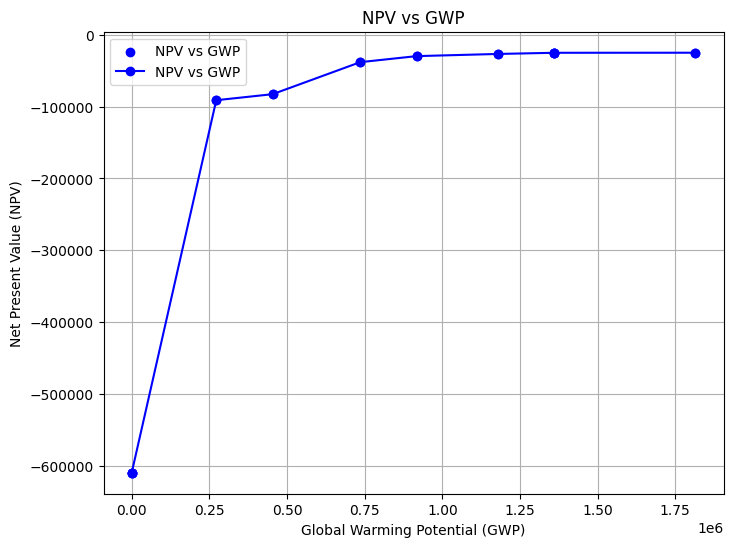

In [14]:

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(GWPs, NPVs, color='b', marker='o', label='NPV vs GWP')
plt.plot(GWPs, NPVs, color='b', linestyle='-', marker='o', label='NPV vs GWP')


# Labels and title
plt.xlabel('Global Warming Potential (GWP)')
plt.ylabel('Net Present Value (NPV)')
plt.title('NPV vs GWP')

# Grid and legend
plt.grid(True)
plt.legend()

# Show plot
plt.show()
